## Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

import os
import sys

sys.path.append(os.path.abspath('..'))

import torch
from src.models.GaussianProcess import GaussianProcessRegressor, SinusoidalKernel, RBFKernel

## Data Generation Function

In [3]:
amplitude = 1
period = np.pi/2

def f(x):
    return amplitude * torch.sin(period * x)


## Creating Gaussian Process

In [15]:
lower_in = 0
upper_in = 10
num_train = 50
x_train = torch.cat([torch.linspace(lower_in, 4, num_train), torch.linspace(6, upper_in, num_train)]).unsqueeze(1).to(torch.device('cuda')).to(torch.float64)
y_train = f(x_train).to(torch.device('cuda')).to(torch.float64)

kernel_sin = SinusoidalKernel(amplitude=1.0, length_scale=1.0, period=0.1).to(torch.device('cuda'))
kernel_exp = RBFKernel(length_scale=1.0, amplitude=1.0).to(torch.device('cuda'))

gp_sin = GaussianProcessRegressor(kernel_sin, noise=0.0, max_iter=5_000, n_restarts=0, batch_size=num_train, lr=0.01, delta=1e-6)
gp_sin = gp_sin.fit(x_train, y_train)

gp_exp = GaussianProcessRegressor(kernel_exp, noise=0.0, max_iter=5_000, n_restarts=0, batch_size=num_train, lr=0.01)
gp_exp = gp_exp.fit(x_train, y_train)

Iteration      0, Loss:     113.25
Iteration     50, Loss:    -182.92
Iteration    100, Loss:    -196.40
Iteration    150, Loss:    -198.05
Iteration    200, Loss:    -201.92
Iteration    250, Loss:    -202.38
Iteration    300, Loss:    -201.51
Iteration    350, Loss:    -202.30
Iteration    400, Loss:    -201.25
Iteration    450, Loss:    -201.87
Iteration    500, Loss:    -202.65
Iteration    550, Loss:    -202.59
Iteration    600, Loss:    -202.60
Iteration    650, Loss:    -201.08
Iteration    700, Loss:    -202.73
Iteration    750, Loss:    -200.82
Iteration    800, Loss:    -201.53
Iteration    850, Loss:    -203.04
Iteration    900, Loss:    -200.84
Iteration    950, Loss:    -203.31
Iteration   1000, Loss:    -200.73
Iteration   1050, Loss:    -201.21
Iteration   1100, Loss:    -201.24
Iteration   1150, Loss:    -203.33
Iteration   1200, Loss:    -203.74
Iteration   1250, Loss:    -203.41
Iteration   1300, Loss:    -204.45
Iteration   1350, Loss:    -200.69
Iteration   1400, Lo

## Plotting GP Samples

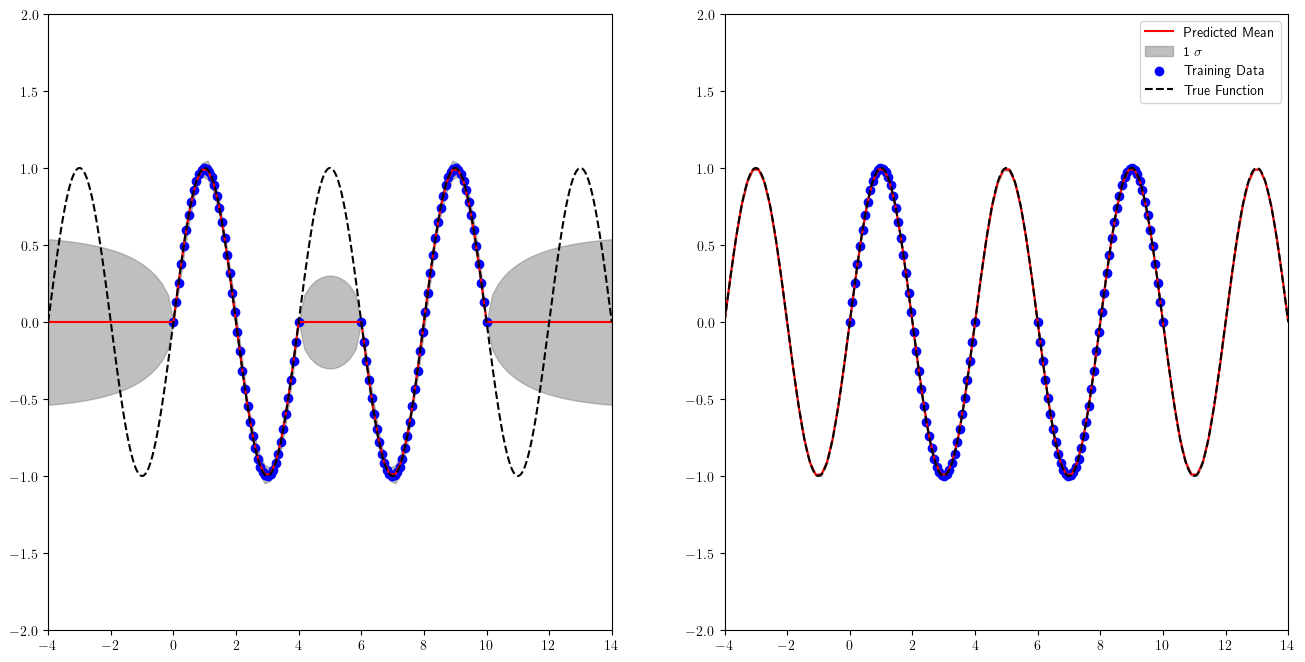

In [14]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

x_test = torch.linspace(-4, 14, 100, device=torch.device('cuda')).unsqueeze(1)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for gp, ax in zip([gp_exp, gp_sin], axs):

    y_pred, y_std = gp.predict(x_test, return_std=True)

    ax.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean')

    upper = y_pred.squeeze() + 1 * y_std
    lower = y_pred.squeeze() - 1 * y_std

    ax.fill_between(to_numpy(x_test).squeeze(), to_numpy(upper), to_numpy(lower), alpha=0.5, color='grey', label=r'1 $\sigma$')

    ax.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='b', marker='o', label='Training Data')

    ax.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function')

    ax.set_xlim(-4, 14)
    ax.set_ylim(-2, 2)

plt.legend()

plt.show()